In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
    
import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")

aux_target_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

2022-04-05 05:25:33.397537: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 05:25:34.650621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-04-05 05:25:34.651884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10545 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [4]:
credit_dsa_dropout = {}
log_credit_dsa_dropout = {}

for dropout in [0.8,0.6,0.4,0.2]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=23, class_num=2, split=3, units=64, ed_act="relu", dropout=dropout)
    credit_dsa_dropout[dropout] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Drop out is {}======".format(dropout))
    print("============================")
    log_credit_dsa_dropout[dropout] = credit_dsa_dropout[dropout].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(),
        batch_size=32,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.00001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.0001,
        verbose=True,
        log_freq=500)

======Drop out is 0.8======
Iteration 500, train accuracy: 0.7752064348459243, average attack MSE: 0.14693602314591409
Iteration 1000, train accuracy: 0.7921072899103164, average attack MSE: 0.13403937710821628
Iteration 1500, train accuracy: 0.7976067731380463, average attack MSE: 0.12233814944326878
Iteration 2000, train accuracy: 0.8010512907505035, average attack MSE: 0.10411789274215698
Iteration 2500, train accuracy: 0.8031949524879456, average attack MSE: 0.08426258869469166
Iteration 3000, train accuracy: 0.8050067224502564, average attack MSE: 0.06613170708715915
Iteration 3500, train accuracy: 0.8062579189538955, average attack MSE: 0.05115793631225824
Iteration 4000, train accuracy: 0.8071322836875916, average attack MSE: 0.039498206440359354
Iteration 4500, train accuracy: 0.8081291036605835, average attack MSE: 0.033107049118727444
Iteration 5000, train accuracy: 0.8087744110822678, average attack MSE: 0.029704770810902118
Iteration 5500, train accuracy: 0.8094312529563904

In [8]:
with open('log/credit-dsa-dropout.pkl', 'wb') as f:
    pickle.dump(log_credit_dsa_dropout, f)

In [27]:
with open('log/credit-dsa.pkl', 'rb') as f:
    log0 = pickle.load(f)[3]

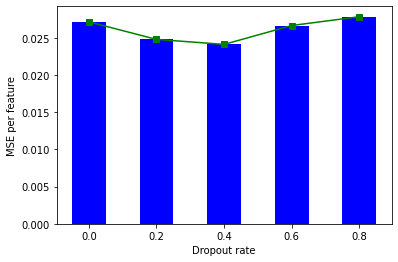

In [57]:
import matplotlib.pyplot as plt

sampled_loss = {}

log_freq = 200
for dropout in [0.8,0.6,0.4,0.2]:
    sampled_loss[dropout] = [sum(log_credit_dsa_dropout[dropout][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_dsa_dropout[dropout][:,0])/log_freq))]
sampled_loss[0] = [sum(log0[:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log0[:,0])/log_freq))]

x = ["0.0", '0.2', '0.4', '0.6', '0.8']
y = [sampled_loss[i][-1] for i in [0,0.2,0.4,0.6,0.8]]
plt.xlabel("Dropout rate")
plt.ylabel("MSE per feature")
plt.bar(x, y, color='b', width=0.5)
plt.plot(x,y,'gs-')
plt.savefig("fig/dsa-dropout.pdf", bbox_inches='tight')